In [1]:
import logging
# set seed
import pandas as pd
import numpy as np
import utils as ut
import experiment as ex
from evaluation import *
from sklearn.metrics import mean_squared_error
from torch.utils.tensorboard import SummaryWriter
import torch
import random
#define fixed_hyperparams and create a config gen
from configurations import RandomConfigGen, Configuration
from torch import nn
from deep_net import RandomNet
from experiment import run_experiment
import regex as re
from pathlib import *
from sk_models import PLSRegression

seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)
random_state = np.random.RandomState(seed)
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU detected is {torch.cuda.get_device_name(0)}")

GPU detected is GeForce GTX 970


In [2]:
#setup input and outpu t formats, load data

#we need to set parametesr
file_name = "mango_684_990.csv"#fitlered=513-1050 #"mango_684_990.csv" #"mango_729_975.csv" 
id_cols =['Set','Season','Region','Date','Type','Cultivar','Pop','Temp',"FruitID"]#
output_cols = ['DM']

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/-1.1") #1.01/")
if not log_path.exists():
    log_path.mkdir()

data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(f"Output directory is {log_dir}")

Output directory is D:\workspace\lazydeep\experiments\-1.1\mango_684_990


In [3]:
data = pd.read_csv(data_file)
nrow, ncol = data.shape
n_features = ncol - 1-len(id_cols)
n_comps = [i for i in range(1,min(101,n_features))]
data = ut.sample_data(data,random_state)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=output_cols, ignore_cols= None)
eval = MangoesSplitter(preprocessing=None,tensorboard=None,time=True,random_state=random_state)
print(f"Dataset shape is {data.shape}")

Dataset shape is (11691, 113)


In [4]:
# set logging, in this case the root logger
ut.setup_logger(logger_name="log",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="test_log",file_name=log_dir/"test_log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
tb = SummaryWriter(log_dir/"tb")
summary_logger = logging.getLogger("summary")
#step 1, run pls, set up pls - that runs best


In [5]:
eval.preprocessing= PLSRegression(n_components=59)
selected_comps=59

### Training the deep learners
The following cells setup our models and run a train-test evaluation.

In [6]:
n_models = 100
epochs = 100
bs = 32
fixed_hyperparams = {'bs': bs,'loss': nn.MSELoss(),'epochs': epochs}
device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#setup models
config_gen = RandomConfigGen(lr= (0,1),
                             allow_increase_size=False,
                             n_features=selected_comps,
                             opt=[torch.optim.SGD,
                                  torch.optim.Adam],
                             lr_update = [None,
                                          torch.optim.lr_scheduler.ReduceLROnPlateau,
                                          torch.optim.lr_scheduler.ExponentialLR,
                                          torch.optim.lr_scheduler.CosineAnnealingLR],
                            dropout = [True,False],
                            batch_norm = [True,False])
configs = {f"random_{i}":config_gen.sample() for i in range(n_models)}
config_gen.save(log_dir/'config_gen.txt')

deep_models = {name:RandomNet(input_size=selected_comps,
                             n_layers=config.n_layers,
                             act_function=config.act_function,
                             n_features = config.n_features,
                             dropout=config.dropout,
                             batch_norm=config.batch_norm,
                             device=device,dtype=torch.float)
              for name, config in configs.items()}

ex.write_summary_head(seed,fixed_hyperparams)
ex.save_models(deep_models,configs,log_dir)
start = datetime.datetime.now()

name = "random_59"
deep_models = {name:deep_models[name]}
configs = {name:configs[name]}
deep_scheme = DeepScheme(configs,fixed_hyperparams=fixed_hyperparams,logger="log",device=device,adaptive_lr=True)
scores_deep, preds_deep, model_states_deep , train_time_deep, test_time_deep, pp_states = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log")


summary_logger.info(f"Train times: {train_time_deep}")
summary_logger.info(f"Test times: {test_time_deep}")
from collections import defaultdict

Starting Experiment'
Seed: 1'
bs: 32'
epochs: 100'
--------------------'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Training extractors on 5879 instances, validating on 1929 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_59:22.3012(-0.751007)'
Tested (val) on 1929 instances with mean losses of: random_59:1.016'
Testing (val) took 0:00:00.296002'
Epoch 0 finished in 0:00:01.388361 '

--- EPOCH 1---'
Extractor Train Losses are random_59:1.2696(-0.773283)'
Tested (val) on 1929 instances with mean losses of: random_59:1.3452'
Testing (val) took 0:00:00.319002'
Epoch 1 finished in 0:00:01.328001 '

--- EPOCH 2---'
Extractor Train Losses are random_59:1.2024(-0.79556)'
Tested (val) on 1929 instances with mean losses of: random_59:1.264'
Testing (val) took 0:00:00.294000'
Epoch 2 finished in 0:00:01.287594 '

--- EPOCH 3---'
Extractor Train Losses are ra

In [7]:
scores_deep_final, preds_deep_final, model_states_deep_final , train_time_deep_final, test_time_deep_final,pp_states_final = eval.build(deep_models,dataset,deep_scheme,logger_name="log")

Building final model - Train 7413 - Test 1448'
Training extractors on 7413 instances, validating on 2830 instances, for 100 epochs'

--- EPOCH 0---'
Extractor Train Losses are random_59:19.6336(-0.751007)'
Tested (val) on 2830 instances with mean losses of: random_59:2.2812'
Testing (val) took 0:00:00.445000'
Epoch 0 finished in 0:00:01.719191 '

--- EPOCH 1---'
Extractor Train Losses are random_59:1.4749(-0.773283)'
Tested (val) on 2830 instances with mean losses of: random_59:1.3877'
Testing (val) took 0:00:00.410999'
Epoch 1 finished in 0:00:01.687152 '

--- EPOCH 2---'
Extractor Train Losses are random_59:1.1501(-0.79556)'
Tested (val) on 2830 instances with mean losses of: random_59:1.2882'
Testing (val) took 0:00:00.436997'
Epoch 2 finished in 0:00:01.664099 '

--- EPOCH 3---'
Extractor Train Losses are random_59:0.9871(-0.817836)'
Tested (val) on 2830 instances with mean losses of: random_59:0.7229'
Testing (val) took 0:00:00.434999'
Epoch 3 finished in 0:00:01.696560 '

--- EPO

In [8]:
ex.save_pp(pp_states,log_dir)
PLSRegression(n_components=selected_comps).save_state(pp_states_final.state(),log_dir / "preprocessing"   / f"_final")

In [9]:
ex.save_results(model_states_deep, preds_deep,configs, scores_deep, log_dir,tb,prefix="")
     
for model, state_dict in model_states_deep_final.items():
     torch.save(state_dict.state(), log_dir / "models" / f"{model}" / f"_final")
        


#summary_logger.info(f"Scores: {scores_deep}")
#for key,value in flip_dicts(scores_deep).items():
#    summary_logger.info(f"{key}: {value}")

end = datetime.datetime.now()
diff = end - start
ex.write_summary(diff, deep_models, scores_deep,prefix="")
ex.save_pred_plots(preds_deep, deep_models,log_dir)


Experiments took 0:13:42.571821'
Finished Random Deep Search'
---Loss results---'
0 - random_59 - fold_0:0.4335,fold_1:0.4428,fold_2:0.3915,fold_3:0.4542,fold_4:0.4478,MSE:0.4341,R2:0.9285'


### Plotting deep results as a function of number of features

In [10]:
scores_df = pd.DataFrame(scores_deep)
scores_df.to_csv(log_dir / f"scores.csv", index=False)

scores_df_final = pd.DataFrame(scores_deep_final)
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)


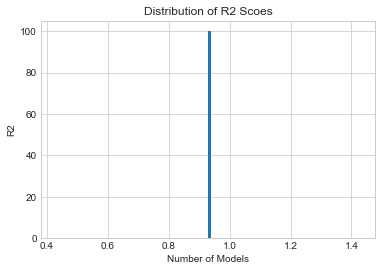

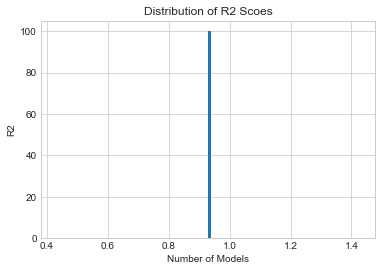

In [11]:
from matplotlib import pyplot as plt
if True:
    # plot deep results as a function of number of features

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')

    n_features_dict = {name:config.n_features for name,config in configs.items()}
    to_plot = pd.DataFrame([[name, scores_deep["R2"][name],n_features_dict[name]] for name in scores_deep["R2"].keys()]
                           ,columns = ["name","score","n_features"])
    to_plot = to_plot[to_plot["score"]>=0]

    fig, ax = plt.subplots()
    ax.hist(to_plot["score"],bins=100,density=True)
    #ax.set_xscale('log')
    #ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
    ax.set_xlabel("Number of Models")
    ax.set_ylabel("R2")
    ax.set_title("Distribution of R2 Scoes")
    plt.savefig(log_dir / f"dist_plot_compressed.png",bbox_inches='tight')
    #plt.savefig(log_dir / f"pp_deep_pls_compressed.png",bbox_inches='tight')
    pass

    #plot


In [12]:
summary_logger.info("------------------\n Top 5 performance on Test Set")
summary_logger.info(f"Index - Model - Val MSE - Val R2 - Test MSE - Test R2")
for i,key in enumerate(sorted(scores_deep['MSE'],key=scores_deep['MSE'].get)):
    if i <5:
        summary_logger.info(f"{i} - {key} - {scores_deep['MSE'][key]} -{scores_deep['R2'][key]} - {scores_deep['MSE'][key]} - {scores_deep_final['MSE'][key]} - {scores_deep_final['R2'][key]}")

------------------
 Top 5 performance on Test Set'
Index - Model - Val MSE - Val R2 - Test MSE - Test R2'
0 - random_59 - 0.43406463829089215 -0.9285156672809534 - 0.43406463829089215 - 0.421224474343811 - 0.9281727840683829'


In [13]:
model_path = Path('D:/workspace/lazydeep/experiments/1.01/')
log_path = Path("D:/workspace/lazydeep/experiments/1.02")

log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
model_dir = model_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)

if not log_dir.exists():
    log_dir.mkdir()
    
ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary2",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary2")
tb = SummaryWriter(log_dir/"tb")

    
    
deep_scores_dict={}
deep_preds_dict={}
actual_y = None
preprocessing=PLSRegression(n_components=selected_comps)

load_fun_cv = lambda name,model, fold : model.load_state(model_dir/'models'/name/f"_fold_{fold}")
load_fun_pp_cv = lambda fold : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_fold_{fold}"))
load_fun_build = lambda name,model : model.load_state(model_dir/'models'/name/f"_final")
load_fun_pp_build = lambda : preprocessing.from_state(preprocessing.load_state(model_dir/'preprocessing'/f"_final"))

deep_scheme = DeepScheme(configs, fixed_hyperparams=fixed_hyperparams,loss_eval=loss_target,device=device,tensorboard=tb,adaptive_lr=False,update=False)
deep_scores, deep_preds, _ , _, _,_ = eval.evaluate(deep_models,dataset,deep_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp=load_fun_pp_cv)


Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Tested (test) on 1905 instances with mean losses of: random_59:0.4134'
Testing (test) took 0:00:00.271999'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Tested (test) on 1955 instances with mean losses of: random_59:0.4268'
Testing (test) took 0:00:00.280999'
-----------------------------------Fold 2 - Train 5821 - Val 1955 - Test 1937-----------------------------------'
Tested (test) on 1937 instances with mean losses of: random_59:0.3867'
Testing (test) took 0:00:00.264000'
-----------------------------------Fold 3 - Train 5787 - Val 1937 - Test 1989-----------------------------------'
Tested (test) on 1989 instances with mean losses of: random_59:0.4572'
Testing (test) took 0:00:00.275515'
-----------------------------------Fold 4 - Train 5797 - Val 1989 - Test 1927

In [14]:
deep_scores_final, deep_preds_final, _ ,_, _,_ = eval.build(deep_models,dataset,deep_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp=load_fun_pp_build)

Building final model - Train 7413 - Test 1448'
Tested (test) on 1448 instances with mean losses of: random_59:0.425'
Testing (test) took 0:00:00.195996'


In [15]:
all_scores = []
for k,v in ut.flip_dicts(deep_scores).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores.append({**dict1,**v})
    
all_scores_final = []
for k,v in ut.flip_dicts(deep_scores_final).items():
    dict1 = {'model_num':k,"predictor":"deep"}
    all_scores_final.append({**dict1,**v})  

scores_df_sorted = pd.DataFrame(all_scores).sort_values(by='MSE')
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    print(s)

0 - random_59 - deep - 0.41344394868440204 - 0.4268353875640713 - 0.38668853449156804 - 0.4572330106437476 - 0.45067953918038345 - 0.42715798708023967 - 0.9296530954646005


In [16]:
from sk_models import setup_pls_models_exh, StandardScaler, PLSRegression
from plot import plot_preds_and_res

for deep_name,deep_model in deep_models.items():
    logging.getLogger().info(f"Running model {deep_name}")
    temp_dict = {deep_name:deep_model}

    lwr_scheme = DeepLWRScheme_1_to_n(lwr_models = setup_pls_models_exh(nrow),n_neighbours=500,loss_fun_sk = mean_squared_error)
    lwr_scores, lwr_preds, _ , _, _,_= eval.evaluate(temp_dict,dataset,lwr_scheme,logger_name="log",load_fun=load_fun_cv,load_fun_pp = load_fun_pp_cv)
    lwr_scores_final, lwr_preds_final, _ , _, _,_= eval.build(temp_dict,dataset,lwr_scheme,logger_name="test_log",load_fun=load_fun_build,load_fun_pp = load_fun_pp_build)

    #scores
    for k,v in ut.flip_dicts(lwr_scores).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores.append({**dict1,**v})

    for k,v in ut.flip_dicts(lwr_scores_final).items():
        dict1 = {'model_num':deep_name,"predictor":k}
        all_scores_final.append({**dict1,**v})

    lwr_preds['deep'] = deep_preds[deep_name]
    lwr_preds_final['deep'] = deep_preds_final[deep_name]

    if not (log_dir/deep_name).exists():
        (log_dir/deep_name).mkdir()    
    
    lwr_preds.to_csv(log_dir/deep_name/ f"predictions.csv",index=False)
    lwr_preds_final.to_csv(log_dir/deep_name/ f"predictions_test.csv",index=False)

    #preds
    # todo save predictions - appending solns
    plot_preds_and_res(lwr_preds,name_lambda=lambda x:f"{deep_name} with {x} predictor",save_lambda= lambda x:f"deep_lwr{x}",save_loc=log_dir/deep_name)



Running model random_59'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 5879 - Val 1929 - Test 1905-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.2714,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.072,lwr_k=40:0.119,lwr_k=50:0.1453,lwr_k=100:0.2067,lwr_k=200:0.2411,lwr_k=300:0.2512,lwr_k=400:0.2571,lwr_k=500:0.2607,lwr_k=600:0.2625,lwr_k=700:0.2641,lwr_k=800:0.2651,lwr_k=900:0.2656,lwr_k=1000:0.2657'
Tested (test) on 1905 instances with mean losses of: lr:0.4141,lwr_k=10:0.7454,lwr_k=20:1.294,lwr_k=30:0.725,lwr_k=40:0.5702,lwr_k=50:0.5256,lwr_k=100:0.4373,lwr_k=200:0.4167,lwr_k=300:0.4127,lwr_k=400:0.4161,lwr_k=500:0.4142,lwr_k=600:0.4159,lwr_k=700:0.4164,lwr_k=800:0.4171,lwr_k=900:0.4158,lwr_k=1000:0.4166'
-----------------------------------Fold 1 - Train 5855 - Val 1903 - Test 1955-----------------------------------'
Finished training DeepLWR with a train loss of lr:0.2708,lwr_k=10:0.0,lwr_k=20:0.0,lwr_k=30:0.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [17]:
scores_df = pd.DataFrame(all_scores)
scores_df.to_csv(log_dir/f"scores.csv",index=False)
scores_df_final = pd.DataFrame(all_scores_final)
scores_df_final.to_csv(log_dir/f"test_scores.csv",index=False)

scores_df_sorted = pd.DataFrame(scores_df).sort_values(by='MSE')

best_5 = []
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    if i < 5:
        best_5.append((row["model_num"],row["predictor"],row["MSE"]))
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)

Rank - model_num - predictor - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - random_59 - lwr_k=200 - 0.4166653531983457 - 0.4312335240577252 - 0.384155462531544 - 0.46337699430476886 - 0.43172619858270145 - 0.42566780548135 - 0.9298985073021006'
1 - random_59 - lwr_k=300 - 0.41274014202117054 - 0.429844055946837 - 0.3888081753748096 - 0.46248178429237957 - 0.43342722952650786 - 0.4257003063813988 - 0.9298931548615869'
2 - random_59 - deep - 0.41344394868440204 - 0.4268353875640713 - 0.38668853449156804 - 0.4572330106437476 - 0.45067953918038345 - 0.42715798708023967 - 0.9296530954646005'
3 - random_59 - lwr_k=500 - 0.4142444910065236 - 0.42971057198811546 - 0.39130599063477484 - 0.46491581217900924 - 0.43543866818952975 - 0.4273640987840034 - 0.92961915168479'
4 - random_59 - lwr_k=400 - 0.4161330397397333 - 0.4316892216683089 - 0.3897847401674108 - 0.46515461254526735 - 0.434173676233281 - 0.4276273148588572 - 0.9295758037042481'
5 - random_59 - lwr_k=600 - 0.415926648837

In [18]:
summary_logger.info("-----------------------\n Best 5 on Test Sest \n ---------------------")
summary_logger.info(f"Rank -  Deep Model - Predictor - Val Set - Test Set")
for i, (j,k,v) in enumerate(best_5):

    row = scores_df_final.loc[(scores_df_final['model_num']==j) & (scores_df_final['predictor'] == k)].iloc[0]
    #print(row)
    s = f"{i} - {j} - {k} - {v} - {row['MSE']} - {row['R2']}"
    summary_logger.info(s)


-----------------------
 Best 5 on Test Sest 
 ---------------------'
Rank -  Deep Model - Predictor - Val Set - Test Set'
0 - random_59 - lwr_k=200 - 0.42566780548135 - 0.4235813499301762 - 0.9277708904110789'
1 - random_59 - lwr_k=300 - 0.4257003063813988 - 0.41870617012542355 - 0.9286022062762397'
2 - random_59 - deep - 0.42715798708023967 - 0.42503891224827856 - 0.9275223459487822'
3 - random_59 - lwr_k=500 - 0.4273640987840034 - 0.4177533215608849 - 0.9287646860535034'
4 - random_59 - lwr_k=400 - 0.4276273148588572 - 0.4187052927674857 - 0.928602355883352'


In [19]:
#take 1 is a scatter plot - lets, for each dataset
#graph our deep models by rank - plot - then overlay our knn moels
#plot points

deep_set = scores_df[scores_df["predictor"]=="deep"].sort_values("R2")
deep_set["order"] = [i for i in range(0,100)]
deep_ordering = {row["model_num"]:row["order"] for index, row in deep_set.iterrows()}

def order_models(x):
    x = [deep_ordering[i] for i in x]
    return x

fig, ax = plt.subplots()
set_deep = False
knn_models = scores_df["predictor"].unique()
for knn_model in knn_models:
    subset = scores_df[scores_df["predictor"]==knn_model]
    s=3
    if knn_model == "deep":
        s=10
    ax.scatter(x=order_models(subset["model_num"].tolist()), y=subset["R2"], s=s, label=knn_model)

#ax.set_ylim(0,scores_db["deep_mean"].max())
ax.set_ylim(0,1)
# plot residuals
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
ax.set_ylabel("R^2 Score")
ax.set_xlabel("Deep Model Rank")
#ax.set_ylim(0,200)
#ax.set_yscale("symlog")
ax.set_title("Summary of LWR improvements over Deep Models")
plt.savefig(log_dir/f"summary_plot.png", bbox_inches='tight')
logging.getLogger().info("Wrote Summary Graph")

ValueError: Length of values (100) does not match length of index (1)

In [ ]:
scores_df["n_features"] = [deep_models[i].n_features for i in scores_df["model_num"]] 
from matplotlib.colors import Colormap
import seaborn as sns #heatmap of features - pls model - score
class nlcmap(Colormap):
    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.N = cmap.N
        self.monochrome = self.cmap.monochrome
        self.levels = np.asarray(levels, dtype='float64')
        self._x = self.levels
        self.levmax = self.levels.max()
        self.levmin = self.levels.min()
        self.transformed_levels = np.linspace(self.levmin, self.levmax, #uniform spacing along levels (colour segments)
             len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = np.interp(xi, self._x, self.transformed_levels)
        return self.cmap((yi-self.levmin) / (self.levmax-self.levmin), alpha)
    
levels = np.concatenate((
    [0, 1],
    [0.6,0.8,0.9,0.95,0.98]
    ))

levels = levels[levels <= 1]
levels.sort()
cmap_nonlin = nlcmap(plt.cm.YlGnBu, levels)


In [ ]:
subset = scores_df[["predictor","n_features","R2"]]
subset = subset[np.logical_not(subset["predictor"]=="deep")]
subset = subset[np.logical_not(subset["predictor"]=="lr")]
trans = subset["predictor"].transform(lambda x: int(x.replace("lwr_k=",""))).tolist()
subset.loc[:,"predictor"]=trans
subset=subset.sort_values("predictor",ascending=False)

def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [ ]:
fig, ax = plt.subplots()
sc = ax.scatter(x=rand_jitter(subset["n_features"]), y=rand_jitter(subset["predictor"]), s=20,c=subset["R2"],cmap=cmap_nonlin,vmin=0)
ax.set_xlabel("Number of Features")
ax.set_ylabel("Number of Neighbours")

cbar = fig.colorbar(sc,label="R2 Score")

ax.set_title("LWR performance as a function of the number of components")
plt.savefig(log_dir/f"heat_scatter.png", bbox_inches='tight')